**Purpose:** This notebook focuses on reducing the feature space in a step-wise fashion. As I am going to use Tree-based model, I have also removed features (that are highly correlated among each other) based on feature importance of tree based models.

In [1]:
import numpy as np
import pandas as pd
# Viz
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df_DataWorkoutRun_aggregated_subscription.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
print(f'Total feature space {df.shape[1]}')
df.head(2)

Total feature space 277


,og.indoor_type_Month1,og.outdoor_type_Month1,og.indoor_type_Month2,og.outdoor_type_Month2,og.indoor_type_Week1,og.outdoor_type_Week1,og.indoor_type_Week2,og.outdoor_type_Week2,og.indoor_type_Week3,og.outdoor_type_Week3,...,health-step-distance_Total.2,Other_health-step-count,apple_health-flights-climbed,health-flights-climbed_Total.2,health-step-distance_Total.3,1_health-step-count,health-step-count_Total.3,kmeans_pred,owner,subscription
0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,7669b71e-8fc4-4e35-a621-ae9d3d8ad370,0
1,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,e84ec03b-d994-44ef-bc2c-3bac691ba5e8,0


## Feature filtering
Here we have high feature space. A strategic way of removing feature would make the model building process more streamlined. Before throwing features based on missing values, I will systemetically eliminate features by removing duplicate features, then constant features, then quasi-constant features, next highly-correlated features, then remove features with high missing values.

**Step 1. Remove duplicate features generted during the aggregation process**

In [3]:
# Remove duplicate columns
duplicated_feat = []
for i in range(0, len(df.columns)):
    col_1 = df.columns[i]
    for col_2 in df.columns[i + 1:]:
        # if the features are duplicated
        if df[col_1].equals(df[col_2]):
            # print them
            print(col_1)
            print(col_2)
            print()
            duplicated_feat.append(col_2)

# could be directly removed, but here I am keeping features with more intuitive names
cols2 = ['session_count_M1', 'Total_Missing_session_M1', 'Total_Missing_session_M1', 'Total_Missing_session_M1',
         'Total_Missing_session_M1', 'Total_Missing_session_M1', 'session_count_M2', 'session_nunique_M2',
         'Total_Missing_session_M2', 'Total_Missing_session_M2', 'Total_Missing_session_M2', 'Total_Missing_session_M2',
         'session_missing_total', 'session_total', 'weekday_session_count', 'weekend_session_count', 'weekend_session_nunique',
         'trackTitle2_Missing', 'Total_Missing_trackTitle_M1', 'Quick Start Program_runDuration_mean',
         'Quick Start Program_runDistance_mean', 'Total_Missing_sessionTitle_M1', 'Total_Missing_trackTitle_M2']
df1 = df.drop(columns=cols2)
print(
    f'No. of columns before removing duplicate features {df.shape[1]}, After removing duplicate features {df1.shape[1]}')

session_count_M1
sessionTitle_count_M1

Total_Missing_session_M1
Total_Missing_session_M2

Total_Missing_session_M1
Total_Missing_sessionTitle_M1

Total_Missing_session_M1
Total_Missing_sessionTitle_M2

Total_Missing_session_M1
Total_Missing_trackTitle_M1

Total_Missing_session_M1
Total_Missing_trackTitle_M2

session_count_M2
sessionTitle_count_M2

session_nunique_M2
sessionTitle_nunique_M2

Total_Missing_session_M2
Total_Missing_sessionTitle_M1

Total_Missing_session_M2
Total_Missing_sessionTitle_M2

Total_Missing_session_M2
Total_Missing_trackTitle_M1

Total_Missing_session_M2
Total_Missing_trackTitle_M2

session_missing_total
sessionTitle2_missing_total

session_total
sessionTitle_total_count

weekday_session_count
weekday_sessiontitle_count

weekend_session_count
weekend_sessiontitle_count

weekend_session_nunique
weekend_sessiontitle_nunique

Total_Missing_sessionTitle_M1
Total_Missing_sessionTitle_M2

Total_Missing_sessionTitle_M1
Total_Missing_trackTitle_M1

Total_Missing_sessio

**Step 2. Removing features that have no variance in itself or constant features and thus no predictive power**

In [4]:
df2 = df1.select_dtypes('number')
print(f'Feature space in the data (only numeric): {df2.shape[1]}')

constant_features = [feat for feat in df2.columns if df2[feat].std() == 0]
df1.drop(columns=constant_features, inplace=True)
df2.drop(columns=constant_features, inplace=True)
print(
    f'After removing {len(constant_features)} constant features, no. of columns for entire dataframe are : {df1.shape[1]}')

Feature space in the data (only numeric): 259
After removing 2 constant features, no. of columns for entire dataframe are : 259


**Step 3. Remove highly correlated features**

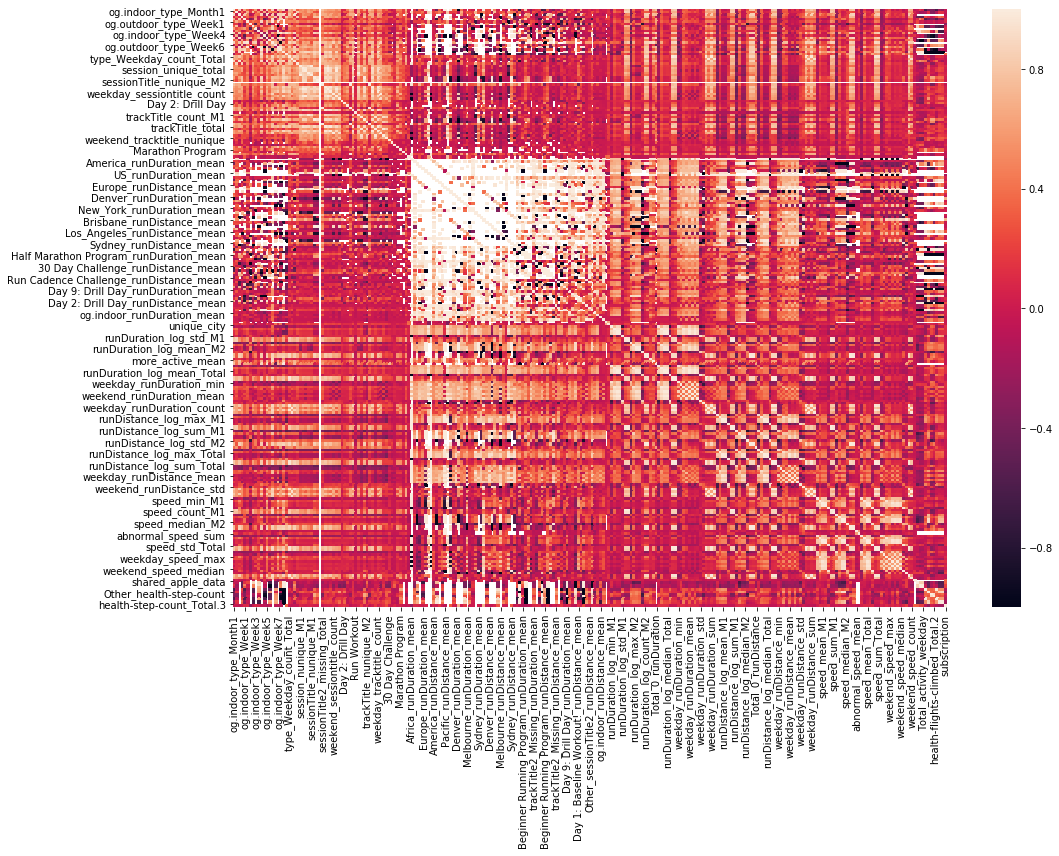

In [5]:
corrmat = df2.corr()
fig, ax = plt.subplots()
fig.set_size_inches(16,11)
sns.heatmap(corrmat);

* **Many features are engineered and aggregated that are highly correlated, we need to remove them**
* **There are highly correlated feature groups** As I will impute with 0 or -9999, I will also use tree-based model to get rid of features that are redundant or with low feature importance, will help to significantly reduce feature space

In [6]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(df2.drop(labels=['subscription'], axis=1),
                                                    df1['subscription'], test_size=0.3, random_state=0)
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train)
X_train1 = pd.DataFrame(X_train1, index=X_train.index, columns=X_train.columns)
X_test1 = sc.transform(X_test)
X_test1 = pd.DataFrame(X_test1, index=X_test.index, columns=X_test.columns)
X_train1.shape, X_test1.shape, y_train.shape, y_test.shape

((574, 256), (247, 256), (574,), (247,))

In [7]:
# build a dataframe with the absolute value of the correlation coefficient between features
corrmat = X_train1.corr()
corrmat = corrmat.abs().unstack()
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.95]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,runDistance_log_sum_M2,Brisbane_runDistance_mean,1.0
1,Other_health-step-count,Asia_runDistance_mean,1.0
2,Brisbane_runDuration_mean,weekend_speed_std,1.0
3,Toronto_runDuration_mean,runDuration_log_std_M2,1.0
4,Marathon Program_runDistance_mean,og.indoor_type_Week8,1.0


In [8]:
# find groups of correlated features
grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + \
            list(correlated_block.feature2.unique()) + [feature]
        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('Found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features \n\n'.format(df2.shape[1]))
print('==================================================================================')
for group in correlated_groups:
    print(group)
    print('\n')

Found 76 correlated groups
out of 257 total features 


                   feature1                    feature2      corr
0    runDistance_log_sum_M2   Brisbane_runDistance_mean  1.000000
8    runDistance_log_sum_M2  Melbourne_runDuration_mean  1.000000
338  runDistance_log_sum_M2    Pacific_runDistance_mean  0.998895
432  runDistance_log_sum_M2    Pacific_runDuration_mean  0.997795
446  runDistance_log_sum_M2      runDuration_log_sum_M2  0.997516
490  runDistance_log_sum_M2    runDistance_log_count_M2  0.996725
503  runDistance_log_sum_M2              speed_count_M2  0.996423
715  runDistance_log_sum_M2                speed_sum_M2  0.989595
797  runDistance_log_sum_M2    runDuration_log_count_M2  0.986449


                     feature1                                   feature2  \
1     Other_health-step-count                      Asia_runDistance_mean   
758   Other_health-step-count  Beginner Running Program_runDistance_mean   
1464  Other_health-step-count                         

**Following function will remove features from each correlated groups that are NOT important for a tree based model**

In [9]:
# Remove correlated features from each correlated_groups through a for loop

cols3 = []
for i in range(len(correlated_groups)):
    #X_train = X_train1
    #X_test = X_test1
    group = correlated_groups[i]

    # Randomforest model with only features from 1 correlated group
    features = list(group.feature2.unique())+list(group.feature1.unique())
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train1[features].fillna(0), y_train)

    # Finding most important features in that correlated group for a RandomForest model
    importance = pd.concat(
        [pd.Series(features), pd.Series(rf.feature_importances_)], axis=1)
    importance.columns = ['feature', 'importance']
    importance.sort_values(by='importance', ascending=False)
    importance = importance.sort_values(by='importance', ascending=False)

    # Only removing correlated features that has low feature importance in tree based models
    not_impt_cols = importance[importance['importance'] < 0.005]
    not_impt_cols = not_impt_cols['feature'].to_list()
    cols3.append(not_impt_cols)

# Finding the columns to remove
cols4 = []
for col in cols3:
    if len(col) == 0:
        pass
    else:
        for i in range(len(col)):
            cols4.append(col[i])

df1 = df1.drop(columns=cols4)
df3 = df2.drop(columns=cols4)
print(
    f'No. of columns to remove that has least importance to the tree based models {len(cols4)}\n')
print(f'After removing the highly correlated features with least importance for a tree based model, \
no. of columns reduced from 259 to {df1.shape[1]}')

No. of columns to remove that has least importance to the tree based models 38

After removing the highly correlated features with least importance for a tree based model, no. of columns reduced from 259 to 245


**Checking whether removing these column improves TREE BASED MODELS (or reduced overfitting) or not?**

In [10]:
X_train2 = X_train1.drop(columns=cols4)
X_test2 = X_test1.drop(columns=cols4)
X_train1.shape, X_test1.shape, X_train2.shape, X_test2.shape

((574, 256), (247, 256), (574, 242), (247, 242))

In [11]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # we are interested in absolute coeff value
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr


corr_features = correlation(X_train2, .98)
print('correlated features: ', len(set(corr_features)))

correlated features:  161


**Which of this 157 features are NOT so important for tree-based models?**

In [12]:
rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train2.fillna(0), y_train)

importance = pd.concat(
    [pd.Series(X_train2.columns), pd.Series(rf.feature_importances_)], axis=1)
importance.columns = ['feature', 'importance']
importance = importance.sort_values(by='importance', ascending=False)
importance.head()

,feature,importance
241,health-step-count_Total.3,0.057797
235,health-step-distance_Total.2,0.050467
239,health-step-distance_Total.3,0.041462
237,apple_health-flights-climbed,0.038709
236,Other_health-step-count,0.033482


In [13]:
cols_with_less_impact = importance[importance['importance'] < 0.005]
cols_with_less_impact = cols_with_less_impact['feature'].to_list()
cols5 = [col for col in corr_features if col in cols_with_less_impact]
print(
    f'Out of 157 correlated features, total unimportant features for tree-based models are: {len(cols5)}')

Out of 157 correlated features, total unimportant features for tree-based models are: 129


In [14]:
df1 = df1.drop(columns=cols5)
df3 = df3.drop(columns=cols5)
df1.shape, df2.shape, df3.shape

((821, 116), (821, 257), (821, 114))

**Lets confirm that we are NOT eliminating any important features for RandomForest model**

In [15]:
# separate train and test sets of original dataframe without removing any correlated features
X_train, X_test, y_train, y_test = train_test_split(df2.drop(labels=['subscription'], axis=1),
                                                    df1['subscription'], test_size=0.2, random_state=0)
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train)
X_train1 = pd.DataFrame(X_train1, index=X_train.index, columns=X_train.columns)
X_test1 = sc.transform(X_test)
X_test1 = pd.DataFrame(X_test1, index=X_test.index, columns=X_test.columns)
print(f'Random forest performance with {X_train1.shape[1]} features\n')

rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train1.fillna(0), y_train)
#print(f'Training set ROC-AUC before removing correlated features: {roc_auc_score(y_train, rf.predict(X_train1.fillna(0)))}')
print(
    f'Test set ROC-AUC before removing correlated features: {roc_auc_score(y_test, rf.predict(X_test1.fillna(0)))}')

Random forest performance with 256 features

Test set ROC-AUC before removing correlated features: 0.5228911319394376


In [16]:
# separate train and test sets of the dataframe after removing any correlated features
X_train, X_test, y_train, y_test = train_test_split(df3.drop(labels=['subscription'], axis=1),
                                                    df1['subscription'], test_size=0.2, random_state=0)
sc = StandardScaler()
X_train2 = sc.fit_transform(X_train)
X_train2 = pd.DataFrame(X_train2, index=X_train.index, columns=X_train.columns)
X_test2 = sc.transform(X_test)
X_test2 = pd.DataFrame(X_test2, index=X_test.index, columns=X_test.columns)
print(f'Random forest performance with {X_train2.shape[1]} features\n')

rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train2.fillna(0), y_train)
#print(f'Training set ROC-AUC before after correlated features: {roc_auc_score(y_train, rf.predict(X_train2.fillna(0)))}')
print(
    f'Test set ROC-AUC before after correlated features: {roc_auc_score(y_test, rf.predict(X_test2.fillna(0)))}')

Random forest performance with 113 features

Test set ROC-AUC before after correlated features: 0.5228911319394376


We reduced our fetaure space less than half and it didn't even impact model accuracy. So steps were correct. Next step would be model building.

In [17]:
# df1 contains 2 additional features that are categorical (not included in this notebook)
df3.shape, df1.shape

((821, 114), (821, 116))

In [18]:
df1.to_csv("df_DataWorkoutRun_4_modelling.csv", index=True)
df = pd.read_csv("df_DataWorkoutRun_4_modelling.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(2)

,og.indoor_type_Month1,og.outdoor_type_Month1,og.indoor_type_Month2,og.outdoor_type_Month2,og.indoor_type_Week1,og.outdoor_type_Week1,og.outdoor_type_Week2,og.indoor_type_Week3,og.outdoor_type_Week3,og.indoor_type_Week4,...,health-step-distance_Total.2,Other_health-step-count,apple_health-flights-climbed,health-flights-climbed_Total.2,health-step-distance_Total.3,1_health-step-count,health-step-count_Total.3,kmeans_pred,owner,subscription
0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,7669b71e-8fc4-4e35-a621-ae9d3d8ad370,0
1,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,e84ec03b-d994-44ef-bc2c-3bac691ba5e8,0


In [42]:
##### Next : Part B. 4.Modeling imbalanced subscriber data (DataWorkoutRun_AppleHealthKit) ######